In [1]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score

# Model
from lightgbm import LGBMClassifier

# Display settings
pd.set_option('display.max_columns', None)


## Data Import and Initial Exploration

Load the application dataset and perform an initial inspection
to understand its structure, size, and column types.


In [2]:
# Load dataset
data = pd.read_csv("C:\\Users\\91784\\Downloads\\application_train.csv")

# Dataset shape
print("Dataset Shape:", data.shape)

# Preview data
data.head()


Dataset Shape: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

## Basic Data Exploration

Inspect column names, data types, and missing values
to understand data quality and preparation requirements.


In [3]:
# Column info and data types
data.info()

# Missing value percentage
missing_pct = (data.isnull().sum() / len(data)) * 100
missing_pct.sort_values(ascending=False).head(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


COMMONAREA_AVG              69.872297
COMMONAREA_MODE             69.872297
COMMONAREA_MEDI             69.872297
NONLIVINGAPARTMENTS_MEDI    69.432963
NONLIVINGAPARTMENTS_MODE    69.432963
NONLIVINGAPARTMENTS_AVG     69.432963
FONDKAPREMONT_MODE          68.386172
LIVINGAPARTMENTS_AVG        68.354953
LIVINGAPARTMENTS_MEDI       68.354953
LIVINGAPARTMENTS_MODE       68.354953
dtype: float64

## Missing Value Analysis

Several housing-related features contain extremely high missing rates
(approximately 65–70%). These variables primarily describe detailed
property characteristics that are not available for most applicants.

Retaining such features without proper handling can introduce noise,
bias, and instability into the model. Therefore, a selective feature
handling strategy is required instead of blanket imputation.


In [4]:
# Identify columns with high missing values (>60%)
missing_threshold = 60

high_missing_cols = missing_pct[missing_pct > missing_threshold].index.tolist()

print("Dropping columns due to high missing values:")
print(high_missing_cols)

# Drop high-missing columns from features
data = data.drop(columns=high_missing_cols)


Dropping columns due to high missing values:
['OWN_CAR_AGE', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'FLOORSMIN_AVG', 'LIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_AVG', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'FLOORSMIN_MODE', 'LIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_MODE', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'FLOORSMIN_MEDI', 'LIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'FONDKAPREMONT_MODE']


In [5]:
import pandas as pd

dropped_columns = [
    "COMMONAREA_AVG", "COMMONAREA_MODE", "COMMONAREA_MEDI",
    "NONLIVINGAPARTMENTS_AVG", "NONLIVINGAPARTMENTS_MODE", "NONLIVINGAPARTMENTS_MEDI",
    "FONDKAPREMONT_MODE", "LIVINGAPARTMENTS_AVG", "LIVINGAPARTMENTS_MODE",
    "LIVINGAPARTMENTS_MEDI", "APARTMENTS_AVG", "APARTMENTS_MODE",
    "APARTMENTS_MEDI", "BASEMENTAREA_AVG", "BASEMENTAREA_MODE",
    "BASEMENTAREA_MEDI", "YEARS_BUILD_AVG"
]

df = pd.DataFrame({
    "Column Name": dropped_columns,
    "Reason": ["High missing value percentage (>60%)"] * len(dropped_columns)
})

df.to_excel("Dropped_Columns_Missing_Value_Treatment.xlsx", index=False)


In [6]:
import pandas as pd

# Read the Excel file
dropped_cols_df = pd.read_excel("Dropped_Columns_Missing_Value_Treatment.xlsx")

# View the contents
dropped_cols_df


,Column Name,Reason
0,COMMONAREA_AVG,High missing value percentage (>60%)
1,COMMONAREA_MODE,High missing value percentage (>60%)
2,COMMONAREA_MEDI,High missing value percentage (>60%)
3,NONLIVINGAPARTMENTS_AVG,High missing value percentage (>60%)
4,NONLIVINGAPARTMENTS_MODE,High missing value percentage (>60%)
5,NONLIVINGAPARTMENTS_MEDI,High missing value percentage (>60%)
6,FONDKAPREMONT_MODE,High missing value percentage (>60%)
7,LIVINGAPARTMENTS_AVG,High missing value percentage (>60%)
8,LIVINGAPARTMENTS_MODE,High missing value percentage (>60%)
9,LIVINGAPARTMENTS_MEDI,High missing value percentage (>60%)


In [7]:
dropped_cols_df.shape


(17, 2)

In [8]:
dropped_cols_df.columns


Index(['Column Name', 'Reason'], dtype='object')

In [9]:
dropped_columns = dropped_cols_df['Column Name'].tolist()


In [10]:
# Recalculate missing percentage after column removal
missing_pct = (data.isnull().sum() / len(data)) * 100
missing_pct.sort_values(ascending=False).head(10)


LANDAREA_AVG          59.376738
LANDAREA_MODE         59.376738
LANDAREA_MEDI         59.376738
BASEMENTAREA_AVG      58.515956
BASEMENTAREA_MODE     58.515956
BASEMENTAREA_MEDI     58.515956
EXT_SOURCE_1          56.381073
NONLIVINGAREA_AVG     55.179164
NONLIVINGAREA_MODE    55.179164
NONLIVINGAREA_MEDI    55.179164
dtype: float64

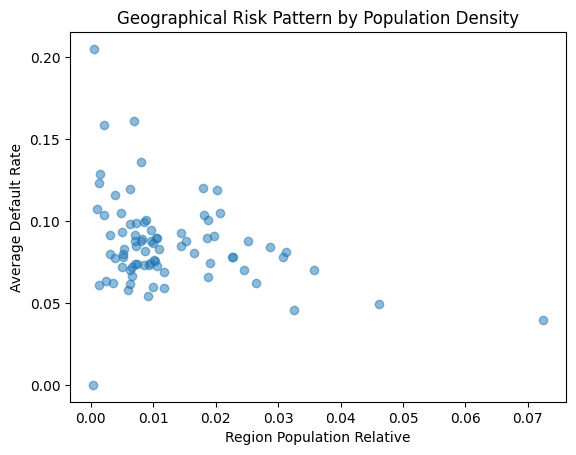

In [11]:
# Group default rate by region population density
geo_risk = data.groupby('REGION_POPULATION_RELATIVE')['TARGET'].mean()

plt.scatter(
    geo_risk.index,
    geo_risk.values,
    alpha=0.5
)

plt.xlabel("Region Population Relative")
plt.ylabel("Average Default Rate")
plt.title("Geographical Risk Pattern by Population Density")
plt.show()


In [12]:
# Calculate percentage of missing values per column
missing_pct = (data.isnull().sum() / len(data)) * 100

# View columns with highest missing values
missing_pct.sort_values(ascending=False).head(15)


LANDAREA_AVG          59.376738
LANDAREA_MODE         59.376738
LANDAREA_MEDI         59.376738
BASEMENTAREA_AVG      58.515956
BASEMENTAREA_MODE     58.515956
BASEMENTAREA_MEDI     58.515956
EXT_SOURCE_1          56.381073
NONLIVINGAREA_AVG     55.179164
NONLIVINGAREA_MODE    55.179164
NONLIVINGAREA_MEDI    55.179164
ELEVATORS_AVG         53.295980
ELEVATORS_MODE        53.295980
ELEVATORS_MEDI        53.295980
WALLSMATERIAL_MODE    50.840783
APARTMENTS_MODE       50.749729
dtype: float64

In [13]:
# Separate numerical and categorical columns
num_cols = data.select_dtypes(include=['int64', 'float64']).columns
cat_cols = data.select_dtypes(include=['object']).columns

print("Number of numerical columns:", len(num_cols))
print("Number of categorical columns:", len(cat_cols))


Number of numerical columns: 90
Number of categorical columns: 15


## Outlier Detection

Detect extreme values in key numerical variables to avoid
model instability caused by unrealistic inputs.


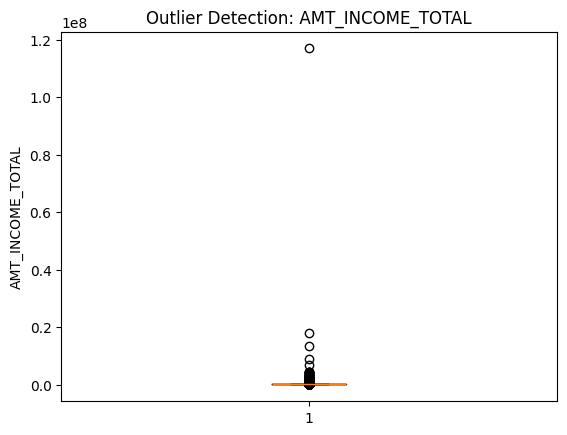

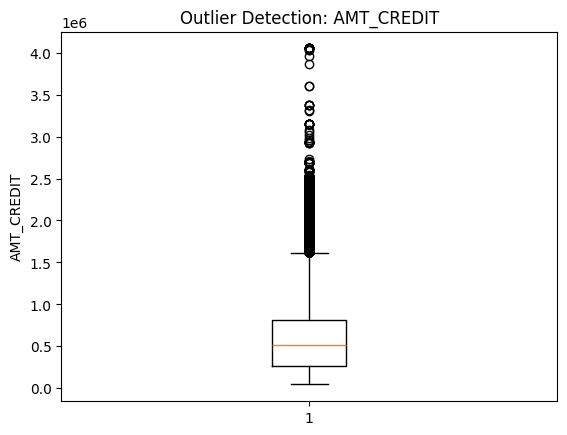

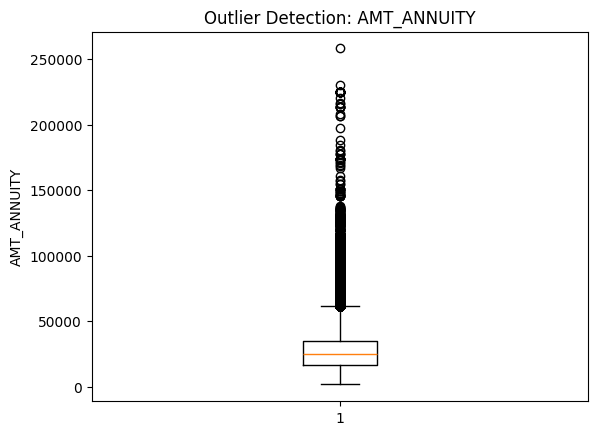

In [14]:
# Visual inspection of outliers for key financial variables
key_numeric_cols = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY']

for col in key_numeric_cols:
    plt.boxplot(data[col].dropna())
    plt.title(f"Outlier Detection: {col}")
    plt.ylabel(col)
    plt.show()


In [15]:
# Define key numerical variables for outlier handling
outlier_cols = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY']

# Cap extreme values at the 99th percentile
for col in outlier_cols:
    upper_limit = data[col].quantile(0.99)
    data[col] = np.where(
        data[col] > upper_limit,
        upper_limit,
        data[col]
    )


In [16]:
# Check for duplicate applicant IDs
duplicate_ids = data.index.duplicated().sum()

print("Number of duplicate applicant records:", duplicate_ids)


Number of duplicate applicant records: 0


In [17]:

# Separate numerical and categorical columns
num_cols = data.select_dtypes(include=['int64', 'float64']).columns
cat_cols = data.select_dtypes(include=['object']).columns

# Numerical columns: median imputation
for col in num_cols:
    data[col] = data[col].fillna(data[col].median())

# Categorical columns: explicit missing category
for col in cat_cols:
    data[col] = data[col].fillna('Unknown')


In [18]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Continuous numerical columns (exclude flags and counts)
zscore_cols = [
    'AMT_INCOME_TOTAL',
    'AMT_CREDIT',
    'AMT_ANNUITY'
]

minmax_cols = [
    'REGION_POPULATION_RELATIVE',
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3'
]


In [19]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['TARGET'])
y = data['TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [20]:
# Z-score standardization
z_scaler = StandardScaler()

X_train[zscore_cols] = z_scaler.fit_transform(X_train[zscore_cols])
X_test[zscore_cols] = z_scaler.transform(X_test[zscore_cols])


In [21]:
# Min-Max normalization
mm_scaler = MinMaxScaler()

X_train[minmax_cols] = mm_scaler.fit_transform(X_train[minmax_cols])
X_test[minmax_cols] = mm_scaler.transform(X_test[minmax_cols])


## Feature Engineering

Create risk-relevant features from application-stage data that capture
financial strength, affordability, stability, and credit stress proxies.

Since only application data is available, behavioral and bureau concepts
are represented using valid application-time proxy features.


In [22]:
# Create new feature dataframe first
new_features = pd.DataFrame(index=data.index)

# Financial Ratios
new_features['DEBT_TO_INCOME'] = data['AMT_CREDIT'] / (data['AMT_INCOME_TOTAL'] + 1)
new_features['ANNUITY_TO_INCOME'] = data['AMT_ANNUITY'] / (data['AMT_INCOME_TOTAL'] + 1)
new_features['CREDIT_UTILIZATION'] = data['AMT_CREDIT'] / (data['AMT_GOODS_PRICE'] + 1)

# Stability Proxies
new_features['EMPLOYMENT_YEARS'] = data['DAYS_EMPLOYED'] / 365
new_features['REGISTRATION_YEARS'] = data['DAYS_REGISTRATION'] / 365
new_features['ID_AGE_YEARS'] = data['DAYS_ID_PUBLISH'] / 365

# Bureau-style Risk Proxies
new_features['EXT_SOURCE_MEAN'] = data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
new_features['EXT_SOURCE_STD'] = data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)

new_features['TOTAL_CREDIT_ENQUIRIES'] = (
    data['AMT_REQ_CREDIT_BUREAU_HOUR'] +
    data['AMT_REQ_CREDIT_BUREAU_DAY'] +
    data['AMT_REQ_CREDIT_BUREAU_WEEK'] +
    data['AMT_REQ_CREDIT_BUREAU_MON'] +
    data['AMT_REQ_CREDIT_BUREAU_QRT'] +
    data['AMT_REQ_CREDIT_BUREAU_YEAR']
)

# Household & Loan Features
new_features['INCOME_PER_PERSON'] = data['AMT_INCOME_TOTAL'] / (data['CNT_FAM_MEMBERS'] + 1)
new_features['CHILDREN_RATIO'] = data['CNT_CHILDREN'] / (data['CNT_FAM_MEMBERS'] + 1)
new_features['LOAN_TENURE'] = data['AMT_CREDIT'] / (data['AMT_ANNUITY'] + 1)

# Concatenate all features at once (NO fragmentation)
data = pd.concat([data, new_features], axis=1)


## Feature Encoding (Weight of Evidence)

Selected categorical features with meaningful credit-risk impact are
encoded using Weight of Evidence (WoE). Binary and administrative
categorical variables are excluded from WoE encoding.

WoE is computed using training data only to prevent target leakage.


In [23]:
# Identify categorical columns
cat_cols = data.select_dtypes(include='object').columns.tolist()
print("Categorical columns available:", cat_cols)


Categorical columns available: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']


In [24]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['TARGET'])
y = data['TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [25]:
def compute_woe(train_df, col, target):
    eps = 1e-4

    grouped = train_df.groupby(col)[target].agg(['sum', 'count'])
    grouped['non_event'] = grouped['count'] - grouped['sum']

    grouped['event_rate'] = grouped['sum'] / grouped['sum'].sum()
    grouped['non_event_rate'] = grouped['non_event'] / grouped['non_event'].sum()

    grouped['woe'] = np.log(
        (grouped['event_rate'] + eps) /
        (grouped['non_event_rate'] + eps)
    )

    return grouped['woe']


In [26]:
# WoE columns (validated)
woe_cols = [
    'NAME_INCOME_TYPE',
    'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE',
    'OCCUPATION_TYPE',
    'ORGANIZATION_TYPE'
]

for col in woe_cols:
    woe_map = compute_woe(
        X_train.join(y_train),
        col,
        'TARGET'
    )

    X_train[col + '_WOE'] = X_train[col].map(woe_map)
    X_test[col + '_WOE'] = X_test[col].map(woe_map)


In [27]:
X_test[col + '_WOE'] = X_test[col + '_WOE'].fillna(0)


In [28]:
X_train.drop(columns=woe_cols, inplace=True)
X_test.drop(columns=woe_cols, inplace=True)


In [29]:
# Confirm no object-type columns remain
X_train.select_dtypes(include='object').columns


Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'WEEKDAY_APPR_PROCESS_START', 'HOUSETYPE_MODE',
       'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

## One-Hot Encoding

After WoE encoding of selected categorical variables, remaining
low-cardinality categorical features are one-hot encoded to convert
all features into numerical form suitable for modeling.


In [30]:
# Remaining categorical columns
remaining_cat_cols = X_train.select_dtypes(include='object').columns.tolist()

print("One-Hot Encoding columns:", remaining_cat_cols)

# Apply One-Hot Encoding
X_train = pd.get_dummies(X_train, columns=remaining_cat_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=remaining_cat_cols, drop_first=True)

# Align train and test feature sets
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)


One-Hot Encoding columns: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'WEEKDAY_APPR_PROCESS_START', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']


In [31]:
# Confirm no categorical columns remain
X_train.select_dtypes(include='object').columns


Index([], dtype='object')

## Class Imbalance Handling

The target variable is highly imbalanced, with default cases forming a
small minority of the dataset. Instead of resampling the data, class
weights are used to penalize misclassification of the minority class
during model training.

This approach preserves the original data distribution and avoids
introducing synthetic observations.


In [32]:
# Check class distribution in training data
y_train.value_counts(normalize=True)


TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

In [33]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute balanced class weights
classes = np.array([0, 1])

weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)

class_weights = {0: weights[0], 1: weights[1]}
print("Class weights:", class_weights)


Class weights: {0: np.float64(0.5439092983356032), 1: np.float64(6.193554884189325)}


## Data Science Modeling

A LightGBM classifier is trained to predict loan default risk.
The model is evaluated using industry-standard metrics suitable
for imbalanced credit risk problems.


In [34]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    class_weight=class_weights,
    random_state=42
)


In [35]:
# Find duplicate columns
dup_cols = X_train.columns[X_train.columns.duplicated()]
print("Duplicate columns:", dup_cols.tolist())


Duplicate columns: []


In [36]:
# Remove duplicate columns from train and test
X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]


In [37]:
# Sanity check
assert X_train.columns.is_unique
assert X_test.columns.is_unique

print("Duplicate columns successfully removed.")


Duplicate columns successfully removed.


In [38]:
# Freeze feature list to prevent future duplication
feature_list = X_train.columns.tolist()


In [39]:
import re

def clean_column_names(df):
    df = df.copy()
    df.columns = [
        re.sub('[^A-Za-z0-9_]+', '_', col)
        for col in df.columns
    ]
    return df

# Clean feature names
X_train = clean_column_names(X_train)
X_test = clean_column_names(X_test)


In [40]:
# No duplicates
assert X_train.columns.is_unique
assert X_test.columns.is_unique

# Same features
assert list(X_train.columns) == list(X_test.columns)

print("Feature names cleaned and validated.")


Feature names cleaned and validated.


In [41]:
model.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11405
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 132
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,300
,subsample_for_bin,200000
,objective,None
,class_weight,"{0: np.float64(0.5439092983356032), 1: np.float64(6.193554884189325)}"
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


## Model Evaluation

The trained LightGBM model is evaluated using AUC-ROC and KS statistic,
which are standard performance metrics for credit risk modeling.


In [42]:
# Predicted probabilities
y_train_proba = model.predict_proba(X_train)[:, 1]
y_test_proba = model.predict_proba(X_test)[:, 1]


In [43]:
from sklearn.metrics import roc_auc_score

train_auc = roc_auc_score(y_train, y_train_proba)
test_auc = roc_auc_score(y_test, y_test_proba)

print(f"Train AUC: {train_auc:.4f}")
print(f"Test  AUC: {test_auc:.4f}")


Train AUC: 0.8190
Test  AUC: 0.7701


In [44]:
from sklearn.metrics import roc_curve
import numpy as np

def ks_statistic(y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    return np.max(tpr - fpr)

train_ks = ks_statistic(y_train, y_train_proba)
test_ks = ks_statistic(y_test, y_test_proba)

print(f"Train KS: {train_ks * 100:.2f}")
print(f"Test  KS: {test_ks * 100:.2f}")


Train KS: 47.89
Test  KS: 40.58


## Dashboard Visualization

A minimal yet effective dashboard is created to summarize portfolio risk,
model performance, key insights, and fairness checks.


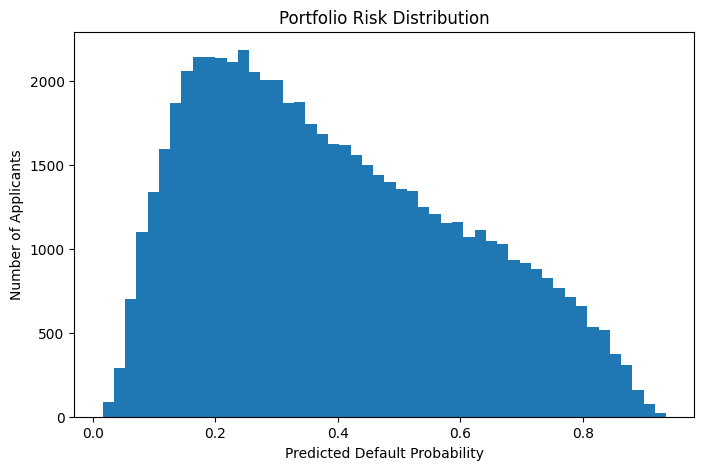

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(y_test_proba, bins=50)
plt.xlabel("Predicted Default Probability")
plt.ylabel("Number of Applicants")
plt.title("Portfolio Risk Distribution")
plt.show()


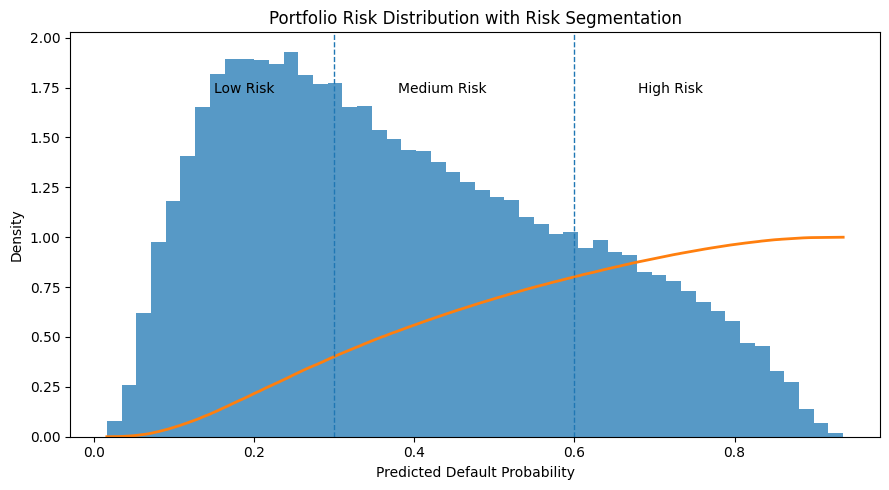

In [46]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5))

# Histogram
plt.hist(
    y_test_proba,
    bins=50,
    density=True,
    alpha=0.75
)

# Density line
plt.plot(
    np.sort(y_test_proba),
    np.linspace(0, 1, len(y_test_proba)),
    linewidth=2
)

# Risk band thresholds
plt.axvline(0.3, linestyle='--', linewidth=1)
plt.axvline(0.6, linestyle='--', linewidth=1)

# Annotations
plt.text(0.15, plt.ylim()[1]*0.85, 'Low Risk', fontsize=10)
plt.text(0.38, plt.ylim()[1]*0.85, 'Medium Risk', fontsize=10)
plt.text(0.68, plt.ylim()[1]*0.85, 'High Risk', fontsize=10)

plt.xlabel("Predicted Default Probability")
plt.ylabel("Density")
plt.title("Portfolio Risk Distribution with Risk Segmentation")

plt.tight_layout()
plt.show()


In [47]:
metrics = {
    "Metric": ["Train AUC", "Test AUC", "Train KS", "Test KS"],
    "Value": [train_auc, test_auc, train_ks * 100, test_ks * 100]
}

import pandas as pd
pd.DataFrame(metrics)


,Metric,Value
0,Train AUC,0.818998
1,Test AUC,0.770102
2,Train KS,47.894674
3,Test KS,40.576920


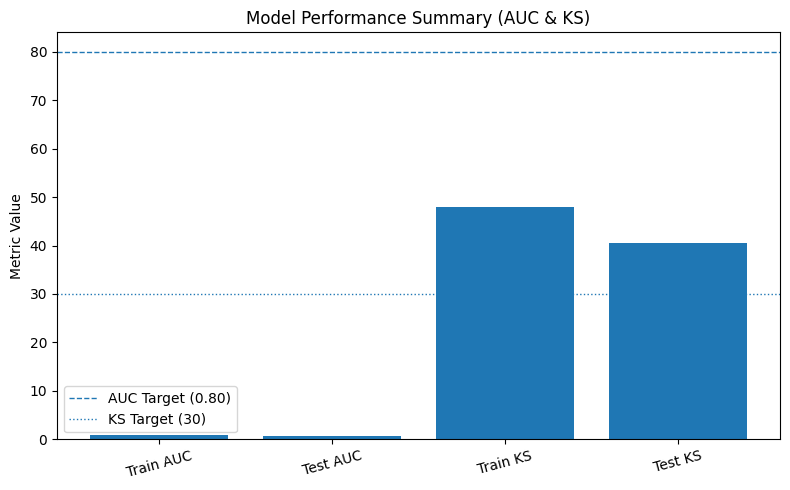

In [48]:
import matplotlib.pyplot as plt

metrics = {
    "Train AUC": train_auc,
    "Test AUC": test_auc,
    "Train KS": train_ks * 100,
    "Test KS": test_ks * 100
}

plt.figure(figsize=(8, 5))

plt.bar(metrics.keys(), metrics.values())

plt.axhline(80, linestyle='--', linewidth=1, label='AUC Target (0.80)')
plt.axhline(30, linestyle=':', linewidth=1, label='KS Target (30)')

plt.ylabel("Metric Value")
plt.title("Model Performance Summary (AUC & KS)")
plt.legend()
plt.xticks(rotation=15)

plt.tight_layout()
plt.show()


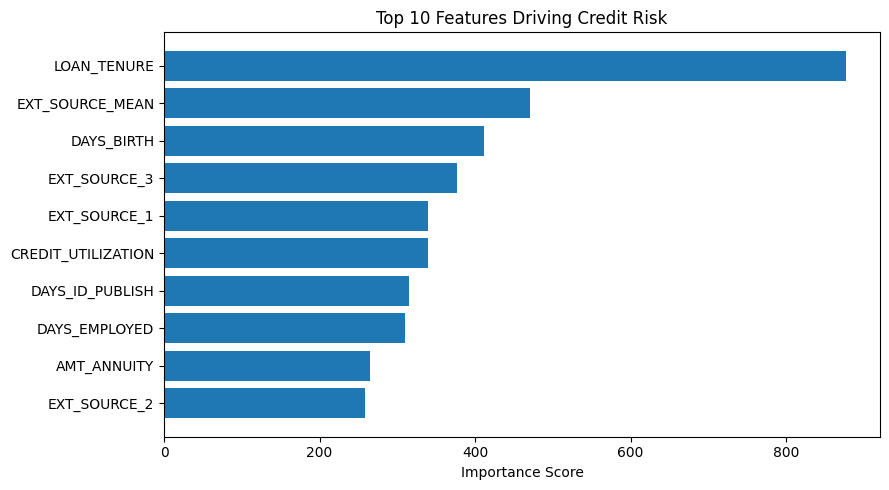

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# Create feature importance dataframe
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Select top 10 features
top_features = importance_df.head(10)

plt.figure(figsize=(9, 5))

plt.barh(
    top_features['Feature'][::-1],
    top_features['Importance'][::-1]
)

plt.xlabel("Importance Score")
plt.title("Top 10 Features Driving Credit Risk")

plt.tight_layout()
plt.show()


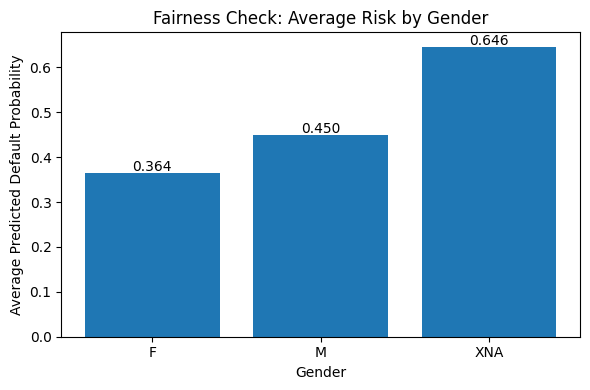

In [50]:
import matplotlib.pyplot as plt
import pandas as pd

# Create fairness dataframe
fairness_df = data.loc[X_test.index, ['CODE_GENDER']].copy()
fairness_df['Predicted_Risk'] = y_test_proba

# Compute average predicted risk by gender
gender_risk = fairness_df.groupby('CODE_GENDER')['Predicted_Risk'].mean()

plt.figure(figsize=(6, 4))

plt.bar(
    gender_risk.index,
    gender_risk.values
)

plt.ylabel("Average Predicted Default Probability")
plt.xlabel("Gender")
plt.title("Fairness Check: Average Risk by Gender")

# Annotate bars
for idx, value in enumerate(gender_risk.values):
    plt.text(idx, value + 0.005, f"{value:.3f}", ha='center')

plt.tight_layout()
plt.show()


## Final Credit Risk Modeling Dashboard

This dashboard provides a consolidated view of portfolio risk,
model performance, key risk drivers, and a fairness check.


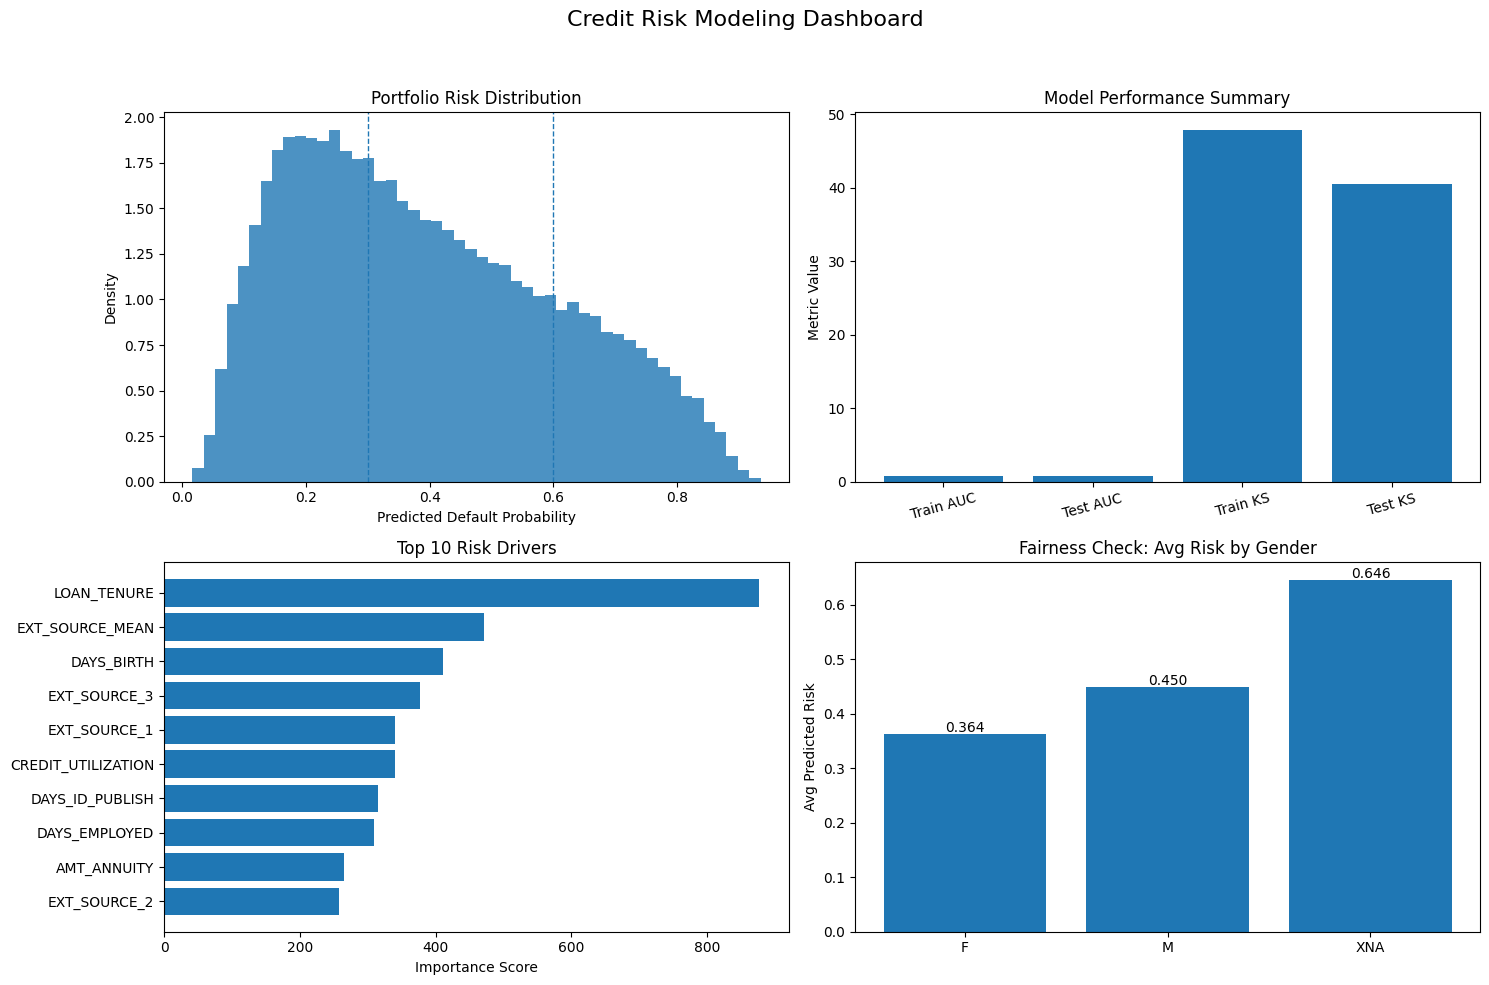

In [51]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Credit Risk Modeling Dashboard", fontsize=16)

# -------------------------------
# 1️⃣ Portfolio Risk Distribution
# -------------------------------
axs[0, 0].hist(y_test_proba, bins=50, density=True, alpha=0.8)
axs[0, 0].axvline(0.3, linestyle='--', linewidth=1)
axs[0, 0].axvline(0.6, linestyle='--', linewidth=1)
axs[0, 0].set_title("Portfolio Risk Distribution")
axs[0, 0].set_xlabel("Predicted Default Probability")
axs[0, 0].set_ylabel("Density")

# -------------------------------
# 2️⃣ Model Performance Summary
# -------------------------------
metrics = ['Train AUC', 'Test AUC', 'Train KS', 'Test KS']
values = [train_auc, test_auc, train_ks * 100, test_ks * 100]

axs[0, 1].bar(metrics, values)
axs[0, 1].set_title("Model Performance Summary")
axs[0, 1].set_ylabel("Metric Value")
axs[0, 1].tick_params(axis='x', rotation=15)

# -------------------------------
# 3️⃣ Insight Bar Chart
# -------------------------------
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False).head(10)

axs[1, 0].barh(
    importance_df['Feature'][::-1],
    importance_df['Importance'][::-1]
)
axs[1, 0].set_title("Top 10 Risk Drivers")
axs[1, 0].set_xlabel("Importance Score")

# -------------------------------
# 4️⃣ Fairness Check
# -------------------------------
fairness_df = data.loc[X_test.index, ['CODE_GENDER']].copy()
fairness_df['Predicted_Risk'] = y_test_proba

gender_risk = fairness_df.groupby('CODE_GENDER')['Predicted_Risk'].mean()

axs[1, 1].bar(gender_risk.index, gender_risk.values)
axs[1, 1].set_title("Fairness Check: Avg Risk by Gender")
axs[1, 1].set_ylabel("Avg Predicted Risk")

for idx, val in enumerate(gender_risk.values):
    axs[1, 1].text(idx, val + 0.003, f"{val:.3f}", ha='center')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## XGBoost Model

An XGBoost classifier is trained as an alternative gradient boosting
model to compare performance against LightGBM using the same feature set.


In [52]:
from xgboost import XGBClassifier


In [53]:
# Calculate scale_pos_weight
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

print("scale_pos_weight:", scale_pos_weight)


scale_pos_weight: 11.38710976837865


In [54]:
xgb_model = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=5,
    min_child_weight=50,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    eval_metric='auc',
    random_state=42,
    n_jobs=-1
)


In [55]:
xgb_model.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


In [56]:
y_test_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
y_train_proba_xgb = xgb_model.predict_proba(X_train)[:, 1]


In [57]:
from sklearn.metrics import roc_auc_score

train_auc_xgb = roc_auc_score(y_train, y_train_proba_xgb)
test_auc_xgb = roc_auc_score(y_test, y_test_proba_xgb)

print(f"XGBoost Train AUC: {train_auc_xgb:.4f}")
print(f"XGBoost Test  AUC: {test_auc_xgb:.4f}")


XGBoost Train AUC: 0.8150
XGBoost Test  AUC: 0.7705


In [58]:
train_ks_xgb = ks_statistic(y_train, y_train_proba_xgb)
test_ks_xgb = ks_statistic(y_test, y_test_proba_xgb)

print(f"XGBoost Train KS: {train_ks_xgb * 100:.2f}")
print(f"XGBoost Test  KS: {test_ks_xgb * 100:.2f}")


XGBoost Train KS: 47.34
XGBoost Test  KS: 40.17


## Model Comparison: LightGBM vs XGBoost

Both models are evaluated using identical datasets and metrics to
compare discriminatory power and generalization.


In [59]:
comparison_df = pd.DataFrame({
    'Model': ['LightGBM', 'XGBoost'],
    'Train AUC': [train_auc, train_auc_xgb],
    'Test AUC': [test_auc, test_auc_xgb],
    'Train KS': [train_ks * 100, train_ks_xgb * 100],
    'Test KS': [test_ks * 100, test_ks_xgb * 100]
})

comparison_df


,Model,Train AUC,Test AUC,Train KS,Test KS
0,LightGBM,0.818998,0.770102,47.894674,40.576920
1,XGBoost,0.814965,0.770507,47.339870,40.167873
